In [1]:
from __future__ import print_function
import os
import cPickle as pickle
import numpy as np
import math

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from deepst.models.STResNet import stresnet
from deepst.config import Config
import deepst.metrics as metrics
from deepst.datasets import TaxiHZ

Using TensorFlow backend.


In [2]:
def build_model(external_dim):
    c_conf = (len_closeness, nb_flow, map_height,
              map_width) if len_closeness > 0 else None
    p_conf = (len_period, nb_flow, map_height,
              map_width) if len_period > 0 else None
    t_conf = (len_trend, nb_flow, map_height,
              map_width) if len_trend > 0 else None

    model = stresnet(c_conf=c_conf, p_conf=p_conf, t_conf=t_conf,
                     external_dim=external_dim, nb_residual_unit=nb_residual_unit)
    adam = Adam(lr=lr)
    model.compile(loss='mse', optimizer=adam, metrics=[metrics.rmse])
    model.summary()
    # from keras.utils.visualize_util import plot
#     plot(model, to_file='model.png', show_shapes=True)
    return model

In [3]:
nb_epoch = 500  # number of epoch at training stage
nb_epoch_cont = 100  # number of epoch at training (cont) stage
batch_size = 32  # batch size
T = 24  # number of time intervals in one day

lr = 0.00002  # learning rate
len_closeness = 3  # length of closeness dependent sequence
len_period = -3  # length of peroid dependent sequence
len_trend = -3  # length of trend dependent sequence
nb_residual_unit = 4   # number of residual units

nb_flow = 2  # there are two types of flows: new-flow and end-flow
days_test = 3
len_test = T * days_test
map_height, map_width = 50, 50  # grid size

model = build_model(None)

conf =  (3, 2, 50, 50)
conv1.shape =  (?, 50, 50, 64)
residual_output.shape =  (?, 50, 50, 64)
conv2.shape =  (?, 50, 50, 2)
external_dim: None
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 6)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 64)   3520        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 50, 50, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 50, 50, 64)   36928      

/home/rgbgroup/HardDrive/JiaxinLiu/virtualenvs/py2torch031/lib/python2.7/site-packages/DeepST-0.0.1-py2.7.egg/deepst/models/STResNet.py:76: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(padding="same", filters=64, kernel_size=(3, 3))`
  nb_filter=64, nb_row=3, nb_col=3, border_mode="same")(input)
/home/rgbgroup/HardDrive/JiaxinLiu/virtualenvs/py2torch031/lib/python2.7/site-packages/DeepST-0.0.1-py2.7.egg/deepst/models/STResNet.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(padding="same", strides=(1, 1), filters=64, kernel_size=(3, 3))`
  return Convolution2D(nb_filter=nb_filter, nb_row=nb_row, nb_col=nb_col, subsample=subsample, border_mode="same")(activation)
/home/rgbgroup/HardDrive/JiaxinLiu/virtualenvs/py2torch031/lib/python2.7/site-packages/DeepST-0.0.1-py2.7.egg/deepst/models/STResNet.py:85: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(padding="same", filters=2, kernel_size=(3, 3))`
  nb_filter=nb_flow, nb_row

In [4]:
X_train, Y_train, X_test, Y_test, mmn, external_dim, timestamp_train, timestamp_test = TaxiHZ.load_data(filepath="./HZ14_M50x50_InOut.hdf5",
        T=T, nb_flow=nb_flow, len_closeness=len_closeness, len_period=len_period, len_trend=len_trend, len_test=len_test,
        preprocess_name='preprocessing.pkl', meta_data=False)

hyperparams_name = 'c{}.p{}.t{}.resunit{}.lr{}'.format(len_closeness, len_period, len_trend, nb_residual_unit, lr)
fname_param = os.path.join('Model', '{}.best.h5'.format(hyperparams_name))
early_stopping = EarlyStopping(monitor='val_rmse', patience=5, mode='min')
model_checkpoint = ModelCheckpoint(fname_param, monitor='val_rmse', verbose=0, save_best_only=True, mode='min')

train_data shape:  (264, 2, 50, 50)
min: 0.0 max: 49684.0
XC shape:  (333, 6, 50, 50) XP shape:  (0,) XT shape:  (0,) Y shape: (333, 2, 50, 50)
XC shape:  (333, 50, 50, 6)
train shape: (261, 50, 50, 6) (261, 50, 50, 2) test shape:  (261, 50, 50, 6) (261, 50, 50, 2)
(261, 50, 50, 6)

(261, 50, 50, 6)



In [5]:
history = model.fit(X_train, Y_train,
                        nb_epoch=nb_epoch,
                        batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=[early_stopping, model_checkpoint],
                        verbose=1)

/home/rgbgroup/HardDrive/JiaxinLiu/virtualenvs/py2torch031/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 234 samples, validate on 27 samples
Epoch 1/500
234/234 [==============================] - 3s 12ms/step - loss: 1.7205 - rmse: 1.3108 - val_loss: 1.4510 - val_rmse: 1.2046
Epoch 2/500
234/234 [==============================] - 0s 1ms/step - loss: 1.2319 - rmse: 1.1079 - val_loss: 0.9076 - val_rmse: 0.9527
Epoch 3/500
234/234 [==============================] - 0s 982us/step - loss: 0.7153 - rmse: 0.8428 - val_loss: 0.4759 - val_rmse: 0.6899
Epoch 4/500
234/234 [==============================] - 0s 967us/step - loss: 0.3681 - rmse: 0.6043 - val_loss: 0.2402 - val_rmse: 0.4901
Epoch 5/500
234/234 [==============================] - 0s 955us/step - loss: 0.1849 - rmse: 0.4282 - val_loss: 0.1222 - val_rmse: 0.3496
Epoch 6/500
234/234 [==============================] - 0s 942us/step - loss: 0.0996 - rmse: 0.3149 - val_loss: 0.0733 - val_rmse: 0.2708
Epoch 7/500
234/234 [==============================] - 0s 934us/step - loss: 0.0630 - rmse: 0.2507 - val_loss: 0.0499 - val_rmse: 0.2233

In [6]:
model.save_weights(os.path.join('Model', '{}.h5'.format(hyperparams_name)), overwrite=True)

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pandas as pd
sns.set(rc={'figure.figsize':(40, 10)})

In [12]:
result = model.predict(X_train)

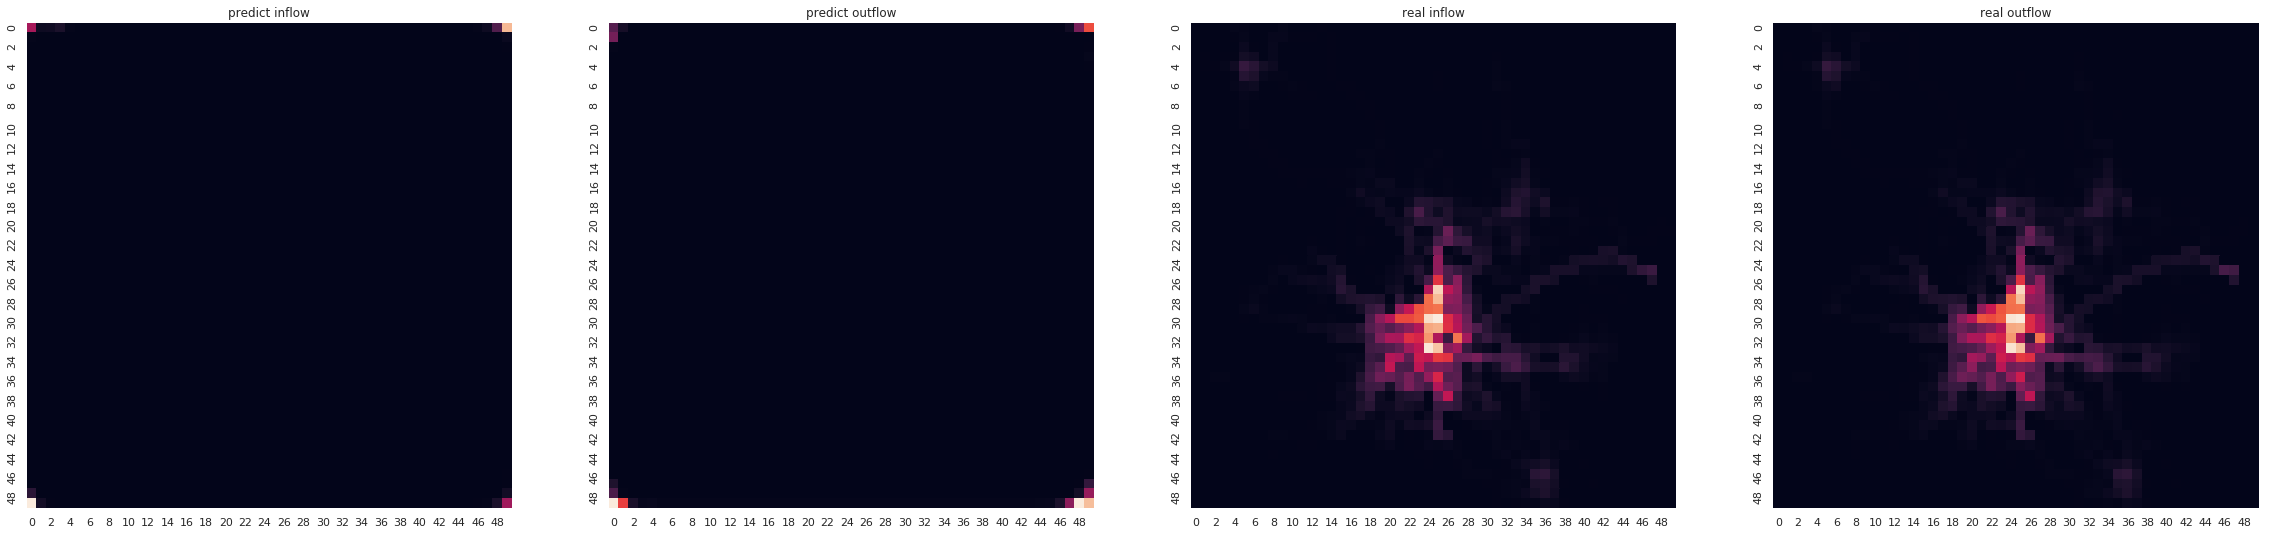

In [13]:
day = 0
hour = 0
todraw = day*24+hour
for i in range(1):
    plt.subplot(1, 4, 4*i+1)
    sns.heatmap(data=pd.DataFrame(result[todraw,:,:,0]), square=True, cbar=False)
    plt.title("predict inflow")
    plt.subplot(1, 4, 4*i+2)
    sns.heatmap(data=pd.DataFrame(result[todraw,:,:,1]), square=True, cbar=False)
    plt.title("predict outflow")
    plt.subplot(1, 4, 4*i+3)
    sns.heatmap(data=pd.DataFrame(Y_train[todraw,:,:,0]), square=True, cbar=False)
    plt.title("real inflow")
    plt.subplot(1, 4, 4*i+4)
    sns.heatmap(data=pd.DataFrame(Y_train[todraw,:,:,1]), square=True, cbar=False)
    plt.title("real outflow")
    plt.show()

In [ ]:
type(X_train)